In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
torch.cuda.empty_cache() 

In [3]:
batch_size = 128
data_path='/home/arsalikhov/Documents/PSYCH420_final_project/mnist'
subset=10

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# reduce datasets by 10x to speed up training
utils.data_subset(mnist_train, subset)
utils.data_subset(mnist_test, subset)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.95
num_steps = 50

In [6]:
class Network(nn.Module):
    def __init__(self, in_features=1, classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_features, 32, kernel_size=3),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.decoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(128, classes),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True))

    def forward(self, data):

        spk_out = self.encoder(data)
        spk_out, mem_out = self.decoder(spk_out)

        return spk_out, mem_out


In [7]:
def forward_pass(net,  data):
    spk_rec = []
    utils.reset(net)

    for step in range(data.size(0)):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)


In [8]:
net = Network(1, 10).to(device)

In [9]:
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [10]:

num_epochs = 1
num_iters = 50

test_acc_hist = []

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):

    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update

        optimizer.zero_grad()
        loss = backprop.BPTT(net, train_loader, optimizer=optimizer, criterion=loss_fn, time_var=True, device=device)
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss)

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
  
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break


UnboundLocalError: local variable 'spk' referenced before assignment

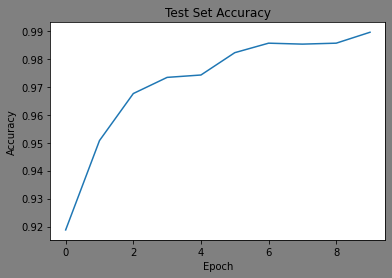

In [ ]:
fig = plt.figure(facecolor="gray")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()